# VGG16 Skin Cancer Binary Classifier using HAM10000 CSV + Image Folder

# This notebook trains a binary classifier (benign vs malignant) on the HAM10000 skin cancer dataset
# using the VGG16 pretrained model with a custom classification head.

# Step 1: Import necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Step 2: Define paths and parameters

In [ ]:
IMG_DIR = '../../Data/HAM10000_Images'  # Folder with all images
CSV_PATH = '../../Data/HAM10000_metadata_binary.csv'  # CSV with image_id and binary_label
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# Step 3: Load and process the metadata CSV
# This ensures each image ID is mapped to a filename and label

In [7]:
# Load the CSV
df = pd.read_csv(CSV_PATH)

# Add '.jpg' to image IDs to match actual filenames
df['filename'] = df['image_id'] + '.jpg'

# Rename label column to match Keras expectations
df['label'] = df['binary_label']

# Print class distribution for sanity check
print("Class distribution:")
print(df['label'].value_counts())

Class distribution:
label
benign       8061
malignant    1954
Name: count, dtype: int64


# Step 4: Create image data generators for training and validation
# This includes augmentation and rescaling

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=10,   zoom_range=0.1
)

# Load training data from dataframe
train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=IMG_DIR,
    x_col='filename',
    y_col='label',
    subset='training',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load validation data from dataframe
val_gen = datagen.flow_from_dataframe(
    dataframe=df,
    directory=IMG_DIR,
    x_col='filename',
    y_col='label',
    subset='validation',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 8012 validated image filenames belonging to 2 classes.
Found 2003 validated image filenames belonging to 2 classes.


# Step 5: Load the VGG16 base model (without top) and add a custom head

In [9]:
# Load pretrained VGG16 model without the classification head
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze all convolutional layers to retain pretrained features
for layer in base_model.layers:
    layer.trainable = False

# Add custom fully connected classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define full model
model = Model(inputs=base_model.input, outputs=predictions)

# Step 6: Compile the model with Adam optimizer and binary cross-entropy loss

In [10]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 7: Train the model on the training set and validate on the validation set

In [11]:
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)

c:\Users\azizc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - accuracy: 0.7438 - loss: 0.5421 - val_accuracy: 0.6046 - val_loss: 0.8994
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.8556 - loss: 0.4119 - val_accuracy: 0.6046 - val_loss: 0.8475
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 616s 2s/step - accuracy: 0.8480 - loss: 0.3884 - val_accuracy: 0.6011 - val_loss: 0.7959
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.8545 - loss: 0.3551 - val_accuracy: 0.5976 - val_loss: 0.8195
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 587s 2s/step - accuracy: 0.8570 - loss: 0.3292 - val_accuracy: 0.5886 - val_loss: 0.8432
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.8664 - loss: 0.3153 - val_accuracy: 0.5681 - val_loss: 0.8350
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.8766 - loss: 0.2979 - val_accuracy: 0.5637 - val_loss: 0.8549
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 599s 2s/step - accuracy: 0.8759 - loss: 0.3023 - val_accu

# Step 8: Evaluate the model on validation data

In [12]:
# Predict class labels and print classification report and confusion matrix
val_gen.reset()
y_true = val_gen.classes
y_pred = model.predict(val_gen, verbose=1)
y_pred_binary = (y_pred > 0.5).astype(int).reshape(-1)

# Print classification metrics
print("Classification Report:")
print(classification_report(y_true, y_pred_binary, target_names=['benign', 'malignant']))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_binary))

63/63 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step
Classification Report:
              precision    recall  f1-score   support

      benign       0.59      0.78      0.67      1211
   malignant       0.35      0.18      0.24       792

    accuracy                           0.54      2003
   macro avg       0.47      0.48      0.46      2003
weighted avg       0.50      0.54      0.50      2003

Confusion Matrix:
[[939 272]
 [646 146]]


# Step 9: Plot training and validation accuracy and loss

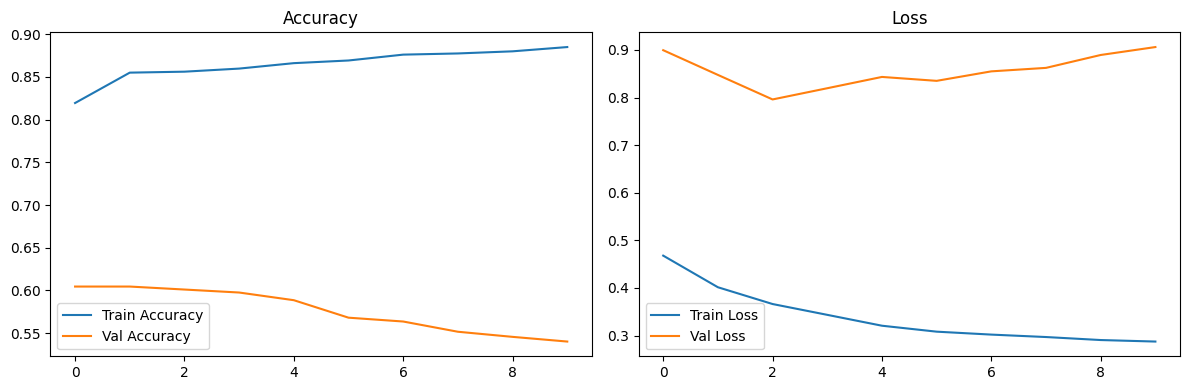

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.show()

# Save the model

In [16]:
model.save('vgg16_skin_cancer.h5')

# Load the model later

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('vgg16_skin_cancer.h5')